# Place features

## Introduction

When selecting events to generate cards from, we want them to be spread out across the geographical extent of the family tree, not clumped around a particular location.

We can achieve this by creating features (numeric values) that represent the location of each event. The clustering step will take these features into account, so that different geographical regions will be represented by different clusters in the output.

## Method

We could create these features by using a geocoding service to search for latitude and longitude of each location. Then, the distance between the two locations would just be the Haversine distance between the two pairs of co-ordinates. However, this either requires access to a third-party (possibly commercial) API, or large amounts of computing resources to run a geocoding instance locally.

We don't actually need the locations to be true to their co-ordinates, we only require that the relative distances between locations are approximate. For example, we would expect that "London, UK" is closer to "Birmingham, UK" than it is to "New York City, NY, US".

We can approximate this by comparing the text similarity of the two locations, and then by performing order reduction to two dimensions. This is relatively inexpensive compared with a geocoding lookup, and gives us something we can work with.

We could refine this model further by tuning the parameters of the model to better reflect the distances between locations with known latitude and longitude, for example from a gazetteer dataset. One trade-off of this approach is that the accuracy of the model would then be sensitive to the training dataset, such that the `timeline-gedcom` project may be less effective for family trees based in regions that weren't covered by the training data.

## Import dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from gedcom5.parser import GEDCOM5Parser
from gedcom5.tag import PLAC
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import Isomap
from sklearn.pipeline import make_pipeline

from common import walk

## Extract data from GEDCOM file

In [2]:
parser = GEDCOM5Parser()

with open("data/royal92.ged") as f:
    gedcom = parser.parse_string(f.read())

## Extract place names

We start by scanning the file for anything that's tagged as a place, and recording it.

In [3]:
places = [tag.value for tag in walk(gedcom) if isinstance(tag, PLAC)]
len(places)

1341

In [4]:
unique_places = list(set(places))
len(unique_places)

715

## Generate features from text similarity

We then create our transformation pipeline. This outputs two features for each location: if two locations have similar values for their respective features, they're assumed to be closer together in physical space.

We can see clear clumps of locations that are close together, which we can isolate using clustering.

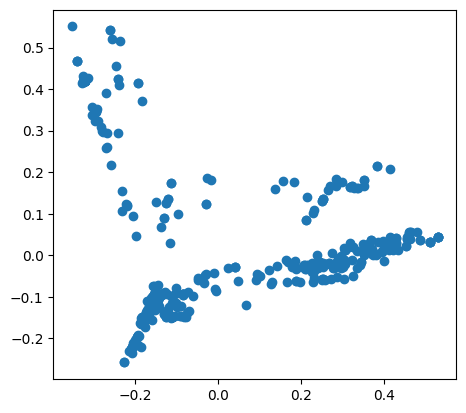

In [5]:
n_neighbors = len(places) - 1

pipeline = make_pipeline(
    CountVectorizer(),
    Isomap(n_neighbors=n_neighbors, metric="cosine"),
)
pipeline.fit(places)

features = pipeline.transform(unique_places)

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.scatter(*features.T);

## Export features

We export the numeric values so we can use them when selecting events.

In [6]:
df = pd.DataFrame(
    data=features,
    columns=["place_0", "place_1"],
    index=unique_places,
)
df.to_csv("data/place_features.csv")
df

,place_0,place_1
"Vicarage Place,Kensington",-0.128251,-0.089317
"Coburg,Germany",-0.206887,-0.221405
Maastricht,-0.147261,-0.092953
Augustenburg,-0.147261,-0.092953
"Near Stanmore,Middlesex,England",0.229933,-0.036825
...,...,...
"Royal Mausoleum,Frogmore,Berkshire,England",0.238519,-0.020116
Kew Palace,0.040132,-0.027996
Utrecht,-0.147261,-0.092953
"St. Germain-,en-Laye,France",-0.242021,0.425076


## Example clustering to explore groups

These plots show how these features could be clustered in isolation.

In [7]:
reference_labels = [
    "Cannes, France",
    "Paris, France",
    "Isle of Wight, England",
    "London, England",
    "Windsor, England",
    "St. Petersburg, Russia",
]
reference_features = pipeline.transform(reference_labels)

reference = pd.DataFrame(reference_features, index=reference_labels)
reference

,0,1
"Cannes, France",-0.321825,0.421450
"Paris, France",-0.340183,0.467939
"Isle of Wight, England",0.249194,-0.030658
"London, England",0.529535,0.044077
"Windsor, England",0.398350,-0.013800
"St. Petersburg, Russia",-0.125730,0.125984


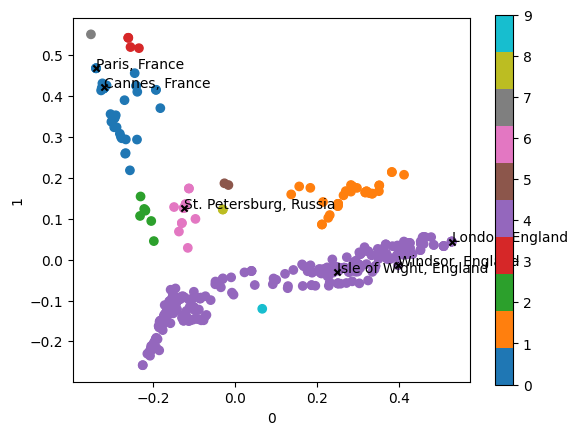

In [8]:
clustering = AgglomerativeClustering(n_clusters=10, linkage="single")
labels = clustering.fit_predict(features)

fig, ax = plt.subplots()
ax.set_aspect(1)
p = ax.scatter(*features.T, c=labels, cmap="tab10")

reference.plot.scatter(0, 1, marker="x", color="black", ax=ax)
for idx, row in reference.iterrows():
    ax.annotate(idx, (row[0], row[1]))

fig.colorbar(p);

In [9]:
df["label"] = labels
df.sort_values("label").groupby("label").head(1)

,place_0,place_1,label
St Denis,-0.193603,0.415224,0
"St. Swithin's,Priory,Winchester,England",0.214988,0.140926,1
"Celestines,Paris",-0.198763,0.045306,2
"St Cyr,France",-0.255818,0.519751,3
"Abbas Tuman,Caucasus,Russia",-0.156083,-0.098991,4
St. James Palac,-0.016385,0.182352,5
"St Stephen Abbey,Caen,Normandy",-0.097004,0.099570,6
France,-0.352585,0.550885,7
"Winter Palace,,St. Petersburg,Russia",-0.030148,0.122574,8
"Winchester,Castle",0.066316,-0.120292,9
